In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction

**Zero-Reference Deep Curve Estimation** or **Zero-DCE** formulates low-light image
enhancement as the task of estimating an image-specific
[*tonal curve*](https://en.wikipedia.org/wiki/Curve_(tonality)) with a deep neural network.
In this example, we train a lightweight deep network, **DCE-Net**, to estimate
pixel-wise and high-order tonal curves for dynamic range adjustment of a given image.

Zero-DCE takes a low-light image as input and produces high-order tonal curves as its output.
These curves are then used for pixel-wise adjustment on the dynamic range of the input to
obtain an enhanced image. The curve estimation process is done in such a way that it maintains
the range of the enhanced image and preserves the contrast of neighboring pixels. This
curve estimation is inspired by curves adjustment used in photo editing software such as
Adobe Photoshop where users can adjust points throughout an image’s tonal range.

Zero-DCE is appealing because of its relaxed assumptions with regard to reference images:
it does not require any input/output image pairs during training.
This is achieved through a set of carefully formulated non-reference loss functions,
which implicitly measure the enhancement quality and guide the training of the network.

### References

- [Zero-Reference Deep Curve Estimation for Low-Light Image Enhancement](https://arxiv.org/abs/2001.06826)
- [Curves adjustment in Adobe Photoshop](https://helpx.adobe.com/photoshop/using/curves-adjustment.html)

## Downloading LOLDataset

The **LoL Dataset** has been created for low-light image enhancement. It provides 485
images for training and 15 for testing. Each image pair in the dataset consists of a
low-light input image and its corresponding well-exposed reference image.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re

import io
import ast
import pandas as pd


from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

## Creating a TensorFlow Dataset

We use 300 low-light images from the LoL Dataset training set for training, and we use
the remaining 185 low-light images for validation. We resize the images to size `256 x
256` to be used for both training and validation. Note that in order to train the DCE-Net,
we will not require the corresponding enhanced images.

In [ ]:
# CSV file path
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/rsicd/train.csv'

# Columns in the CSV
filename_column = 'filename'
image_data_column = 'image'

# Output directory for extracted images
output_directory = 'RSICD_train/'

create_directory = 'RSICD_train/rsicd_images/'

if not os.path.exists(create_directory):
    os.makedirs(create_directory)


# Load the CSV file
df = pd.read_csv(csv_file_path)

# Initialize an empty list to store valid captions
list_captions_train = []
text_data = []  # Initialize text_data
valid_indices = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Process the captions
    cap = row["captions"]
    cap = cap.replace("[", " ").replace("]", " ").replace("'", " ")
    list_captions = ["<start> " + element.strip() + " <end>" for element in re.split(r'[\n\.]', cap) if element.strip()]

    # Check if the list of captions has exactly 5 elements
    if len(list_captions) == 5:
        list_captions_train.append(list_captions)
        text_data.extend(list_captions)  # Append valid captions to text_data
        valid_indices.append(index)  # Store the index of valid rows

        # Process and save the image
        filename = row[filename_column]
        image_data = row[image_data_column]

        image = Image.open(io.BytesIO((ast.literal_eval(image_data)['bytes'])))
        output_path = os.path.join(output_directory, filename)
        row[filename_column] = output_path
        image.save(output_path)
        print(f"Saved: {output_path}")
    else:
        print(f"Skipping image and captions for: {row[filename_column]} due to invalid caption count")

# Keep only the valid rows in df_train
df_train = df.loc[valid_indices].copy()

print("Image extraction and caption filtering complete.")
print(f"Number of valid captions in text_data: {len(text_data)}")


Streaming output truncated to the last 5000 lines.
Saved: RSICD_train/rsicd_images/mediumresidential_261.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_262.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_263.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_264.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_265.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_266.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_267.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_268.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_269.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_27.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_270.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_271.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_272.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_273.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_274.jpg
Saved: RSICD_train/rsicd_images/mediumresidential_275.jpg
Saved: RSICD_train/rsi

In [ ]:
import csv

csv_file_path = '/content/drive/MyDrive/Colab Notebooks/rsicd/valid.csv'

# Columns in the CSV
filename_column = 'filename'
image_data_column = 'image'

# Output directory for extracted images
output_directory = 'RSICD_valid/'


create_directory = "RSICD_valid/rsicd_images/"
if not os.path.exists(create_directory):
    os.makedirs(create_directory)

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Initialize an empty list to store valid captions
list_captions_valid = []
valid_indices = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Process the captions
    cap = row["captions"]
    cap = cap.replace("[", " ").replace("]", " ").replace("'", " ")
    list_captions = ["<start> " + element.strip() + " <end>" for element in re.split(r'[\n\.]', cap) if element.strip()]

    # Check if the list of captions has exactly 5 elements
    if len(list_captions) == 5:
        list_captions_valid.append(list_captions)
        valid_indices.append(index)  # Store the index of valid rows

        # Process and save the image
        filename = row[filename_column]
        image_data = row[image_data_column]

        image = Image.open(io.BytesIO((ast.literal_eval(image_data)['bytes'])))
        output_path = os.path.join(output_directory, filename)
        row[filename_column] = output_path
        image.save(output_path)
        print(f"Saved: {output_path}")
    else:
        print(f"Skipping image and captions for: {row[filename_column]} due to invalid caption count")

# Keep only the valid rows in df_valid
df_valid = df.loc[valid_indices].copy()

print("Image extraction and caption filtering complete.")


Saved: RSICD_valid/rsicd_images/airport_61.jpg
Saved: RSICD_valid/rsicd_images/airport_62.jpg
Saved: RSICD_valid/rsicd_images/airport_63.jpg
Saved: RSICD_valid/rsicd_images/airport_64.jpg
Saved: RSICD_valid/rsicd_images/airport_65.jpg
Saved: RSICD_valid/rsicd_images/airport_66.jpg
Saved: RSICD_valid/rsicd_images/airport_67.jpg
Saved: RSICD_valid/rsicd_images/airport_68.jpg
Saved: RSICD_valid/rsicd_images/airport_69.jpg
Saved: RSICD_valid/rsicd_images/airport_7.jpg
Saved: RSICD_valid/rsicd_images/airport_70.jpg
Saved: RSICD_valid/rsicd_images/airport_71.jpg
Skipping image and captions for: rsicd_images/airport_72.jpg due to invalid caption count
Saved: RSICD_valid/rsicd_images/airport_73.jpg
Saved: RSICD_valid/rsicd_images/airport_74.jpg
Saved: RSICD_valid/rsicd_images/airport_75.jpg
Saved: RSICD_valid/rsicd_images/airport_76.jpg
Saved: RSICD_valid/rsicd_images/airport_77.jpg
Saved: RSICD_valid/rsicd_images/airport_78.jpg
Skipping image and captions for: rsicd_images/airport_79.jpg due 

In [ ]:
import csv

csv_file_path = '/content/drive/MyDrive/Colab Notebooks/rsicd/test.csv'

# Columns in the CSV
filename_column = 'filename'
image_data_column = 'image'

# Output directory for extracted images
output_directory = 'RSICD_test/'


create_directory = "RSICD_test/rsicd_images/"
if not os.path.exists(create_directory):
    os.makedirs(create_directory)

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Initialize an empty list to store valid captions
list_captions_test = []
valid_indices = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Process the captions
    cap = row["captions"]
    cap = cap.replace("[", " ").replace("]", " ").replace("'", " ")
    list_captions = ["<start> " + element.strip() + " <end>" for element in re.split(r'[\n\.]', cap) if element.strip()]

    # Check if the list of captions has exactly 5 elements
    if len(list_captions) == 5:
        list_captions_test.append(list_captions)
        text_data.extend(list_captions) # it is used in vectorization of valid captions
        valid_indices.append(index)  # Store the index of valid rows

        # Process and save the image
        filename = row[filename_column]
        image_data = row[image_data_column]

        image = Image.open(io.BytesIO((ast.literal_eval(image_data)['bytes'])))
        output_path = os.path.join(output_directory, filename)
        row[filename_column] = output_path
        image.save(output_path)
        print(f"Saved: {output_path}")
    else:
        print(f"Skipping image and captions for: {row[filename_column]} due to invalid caption count")

# Keep only the valid rows in df_valid
df_test = df.loc[valid_indices].copy()

print("Image extraction and caption filtering complete.")


Saved: RSICD_test/rsicd_images/airport_348.jpg
Saved: RSICD_test/rsicd_images/airport_349.jpg
Skipping image and captions for: rsicd_images/airport_35.jpg due to invalid caption count
Skipping image and captions for: rsicd_images/airport_350.jpg due to invalid caption count
Saved: RSICD_test/rsicd_images/airport_351.jpg
Skipping image and captions for: rsicd_images/airport_352.jpg due to invalid caption count
Saved: RSICD_test/rsicd_images/airport_353.jpg
Saved: RSICD_test/rsicd_images/airport_354.jpg
Saved: RSICD_test/rsicd_images/airport_355.jpg
Saved: RSICD_test/rsicd_images/airport_356.jpg
Saved: RSICD_test/rsicd_images/airport_357.jpg
Skipping image and captions for: rsicd_images/airport_358.jpg due to invalid caption count
Saved: RSICD_test/rsicd_images/airport_359.jpg
Saved: RSICD_test/rsicd_images/airport_36.jpg
Saved: RSICD_test/rsicd_images/airport_360.jpg
Saved: RSICD_test/rsicd_images/airport_37.jpg
Saved: RSICD_test/rsicd_images/airport_38.jpg
Saved: RSICD_test/rsicd_image

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("/content/RSICD_train/rsicd_images/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/RSICD_valid/rsicd_images/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("/content/RSICD_test/rsicd_images/*"))




train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>




```
# This is formatted as code
```

## The Zero-DCE Framework

The goal of DCE-Net is to estimate a set of best-fitting light-enhancement curves
(LE-curves) given an input image. The framework then maps all pixels of the input’s RGB
channels by applying the curves iteratively to obtain the final enhanced image.

### Understanding light-enhancement curves

A ligh-enhancement curve is a kind of curve that can map a low-light image
to its enhanced version automatically,
where the self-adaptive curve parameters are solely dependent on the input image.
When designing such a curve, three objectives should be taken into account:

- Each pixel value of the enhanced image should be in the normalized range `[0,1]`, in order to
avoid information loss induced by overflow truncation.
- It should be monotonous, to preserve the contrast between neighboring pixels.
- The shape of this curve should be as simple as possible,
and the curve should be differentiable to allow backpropagation.

The light-enhancement curve is separately applied to three RGB channels instead of solely on the
illumination channel. The three-channel adjustment can better preserve the inherent color and reduce
the risk of over-saturation.

![](https://li-chongyi.github.io/Zero-DCE_files/framework.png)

### DCE-Net

The DCE-Net is a lightweight deep neural network that learns the mapping between an input
image and its best-fitting curve parameter maps. The input to the DCE-Net is a low-light
image while the outputs are a set of pixel-wise curve parameter maps for corresponding
higher-order curves. It is a plain CNN of seven convolutional layers with symmetrical
concatenation. Each layer consists of 32 convolutional kernels of size 3×3 and stride 1
followed by the ReLU activation function. The last convolutional layer is followed by the
Tanh activation function, which produces 24 parameter maps for 8 iterations, where each
iteration requires three curve parameter maps for the three channels.

![](https://i.imgur.com/HtIg34W.png)

In [ ]:

def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)


## Loss functions

To enable zero-reference learning in DCE-Net, we use a set of differentiable
zero-reference losses that allow us to evaluate the quality of enhanced images.

### Color constancy loss

The *color constancy loss* is used to correct the potential color deviations in the
enhanced image.

In [ ]:

def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = (
        mean_rgb[:, :, :, 0],
        mean_rgb[:, :, :, 1],
        mean_rgb[:, :, :, 2],
    )
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))


### Exposure loss

To restrain under-/over-exposed regions, we use the *exposure control loss*.
It measures the distance between the average intensity value of a local region
and a preset well-exposedness level (set to `0.6`).

In [ ]:

def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


### Illumination smoothness loss

To preserve the monotonicity relations between neighboring pixels, the
*illumination smoothness loss* is added to each curve parameter map.

In [ ]:

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


### Spatial consistency loss

The *spatial consistency loss* encourages spatial coherence of the enhanced image by
preserving the contrast between neighboring regions across the input image and its enhanced version.

In [ ]:

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_right = tf.nn.conv2d(
            original_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


### Deep curve estimation model

We implement the Zero-DCE framework as a Keras subclassed model.

In [ ]:

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(
            name="illumination_smoothness_loss"
        )
        self.spatial_constancy_loss_tracker = keras.metrics.Mean(
            name="spatial_constancy_loss"
        )
        self.color_constancy_loss_tracker = keras.metrics.Mean(
            name="color_constancy_loss"
        )
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.spatial_constancy_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


## Training

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 395ms/step - color_constancy_loss: 0.0756 - exposure_loss: 0.3101 - illumination_smoothness_loss: 25.9439 - spatial_constancy_loss: 0.0018 - total_loss: 26.3314 - val_color_constancy_loss: 0.0184 - val_exposure_loss: 0.7336 - val_illumination_smoothness_loss: 23.9033 - val_spatial_constancy_loss: 7.5371e-04 - val_total_loss: 24.6562
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - color_constancy_loss: 0.0326 - exposure_loss: 0.3251 - illumination_smoothness_loss: 13.5883 - spatial_constancy_loss: 8.8169e-04 - total_loss: 13.9469 - val_color_constancy_loss: 0.0164 - val_exposure_loss: 0.7404 - val_illumination_smoothness_loss: 14.9699 - val_spatial_constancy_loss: 4.7701e-04 - val_total_loss: 15.7273
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - color_constancy_loss: 0.0182 - exposure_loss: 0.3281 - illumination_smoothness_loss: 7.8031 - spatial_constancy_loss: 6.0516e-04 - total_loss: 8.1500 - val_color_constancy_loss: 0.0199 

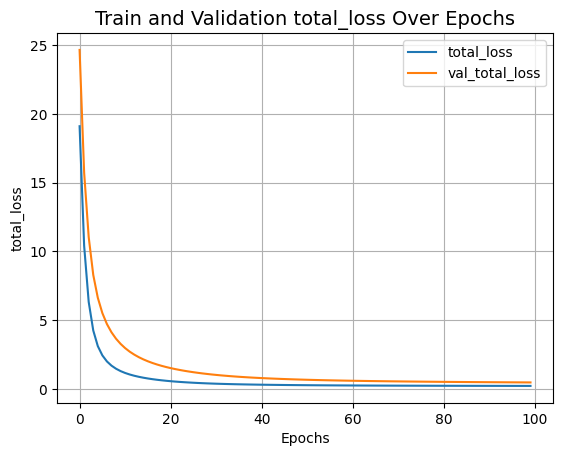

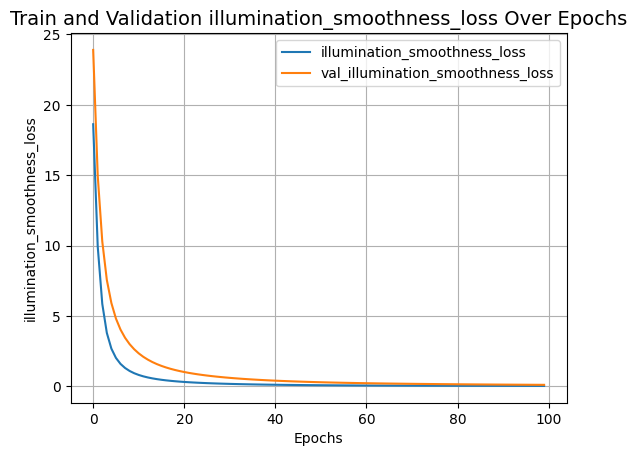

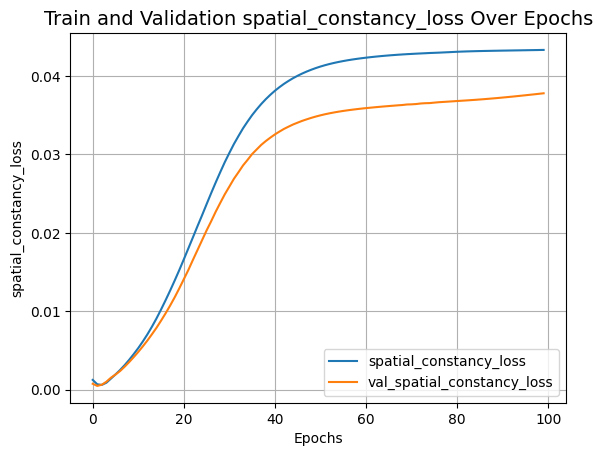

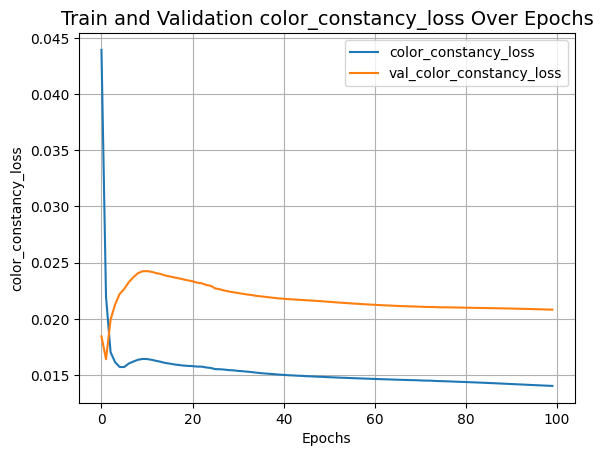

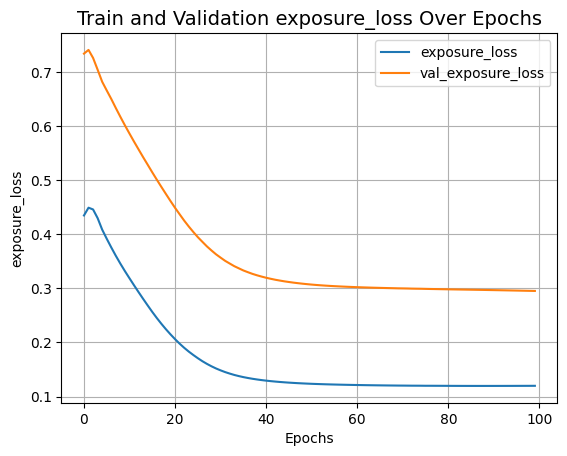

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=100)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

## Inference

In [ ]:

def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


### Inference on test images

We compare the test images from LOLDataset enhanced by MIRNet with images enhanced via
the `PIL.ImageOps.autocontrast()` function.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/low-light-image-enhancement)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/low-light-image-enhancement).

In [ ]:
output_folder = 'RSICD_train/rsicd_images'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# this is used for future enhancing the train images
enhancing_train_images = sorted(glob("/content/RSICD_train/rsicd_images/*"))

# Loop through the images
for idx, val_image_file in enumerate(enhancing_train_images):
    # Open the original image
    original_image = Image.open(val_image_file)

    # Apply the enhancement (assumed 'infer' is your enhancement function)
    enhanced_image = infer(original_image)

    # Extract the original file name (without the directory path)
    original_file_name = os.path.basename(val_image_file)

    # Generate a unique file name for the enhanced image
    output_path = os.path.join(output_folder, original_file_name)#f"enhanced_image_{idx}.png")

    # Save the enhanced image to the designated folder
    enhanced_image.save(output_path)


In [ ]:
# Define the folder where you want to save the enhanced images
output_folder = 'RSICD_test/rsicd_images'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through the images
for idx, val_image_file in enumerate(test_low_light_images):
    # Open the original image
    original_image = Image.open(val_image_file)

    # Apply the enhancement (assumed 'infer' is your enhancement function)
    enhanced_image = infer(original_image)

    # Extract the original file name (without the directory path)
    original_file_name = os.path.basename(val_image_file)

    # Generate a unique file name for the enhanced image
    output_path = os.path.join(output_folder, original_file_name)#f"enhanced_image_{idx}.png")

    # Save the enhanced image to the designated folder
    enhanced_image.save(output_path)


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import io
import ast
import pandas as pd


import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

In [ ]:
# Path to the images
IMAGES_PATH = "/content/RSCID/rsicd_images"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# enhanced_image_path = os.path.join(enhanced_directory, os.path.basename(original_filename))
# print(enhanced_image_path)

In [ ]:
# # CSV file path
# csv_file_path = '/content/drive/MyDrive/dataset/rsicd/train.csv'

# # Columns in the CSV
# filename_column = 'filename'
# image_data_column = 'image'

# # Directory where enhanced images are saved
# enhanced_directory = 'enhanced_image_train/rsicd_images/'

# # Load the CSV file
# df = pd.read_csv(csv_file_path)

# # Initialize lists for valid captions and image paths
# list_captions_train = []
# valid_indices = []

# # Iterate over each row in the DataFrame to process captions and filenames
# for index, row in df.iterrows():
#     cap = row["captions"]
#     cap = cap.replace("[", " ").replace("]", " ").replace("'", " ")
#     list_captions = ["<start> " + element.strip() + " <end>" for element in re.split(r'[\n\.]', cap) if element.strip()]

#     # Check if the list of captions has exactly 5 elements
#     if len(list_captions) == 5:
#         list_captions_train.append(list_captions)
#         valid_indices.append(index)

#         # Process the filename and get the enhanced image path
#         original_filename = row[filename_column]
#         enhanced_image_path = os.path.join(enhanced_directory, os.path.basename(original_filename))

#         # Update the filename with the enhanced image path if exists
#         if os.path.exists(enhanced_image_path):
#             row[filename_column] = enhanced_image_path
#             print(f"Updated: {enhanced_image_path}")
#         else:
#             print(f"Enhanced image not found for: {original_filename}")
#     else:
#         print(f"Skipping image and captions for: {row[filename_column]} due to invalid caption count")

# # Keep only valid rows in df_train
# df_train = df.loc[valid_indices].copy()

# # Final number of valid captions
# print(f"Number of valid captions in text_data: {len(list_captions_train)}")


In [ ]:
# # preparing dataset for valid.csv
# # CSV file path
# csv_file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/rsicd/test.csv'

# # Columns in the CSV
# filename_column = 'filename'
# image_data_column = 'image'

# # Output directory for extracted images
# output_directory = 'RSICD/'
# enhanced_directory = 'enhanced_image_test/rsicd_images/'  # Directory where enhanced images are saved


# # Load the CSV file
# df = pd.read_csv(csv_file_path)

# # Initialize an empty list to store valid captions
# list_captions_valid = []
# valid_indices = []

# # Iterate over each row in the DataFrame
# for index, row in df.iterrows():
#     # Process the captions
#     cap = row["captions"]
#     cap = cap.replace("[", " ").replace("]", " ").replace("'", " ")
#     list_captions = ["<start> " + element.strip() + " <end>" for element in re.split(r'[\n\.]', cap) if element.strip()]

#     # Check if the list of captions has exactly 5 elements
#     if len(list_captions) == 5:
#         list_captions_valid.append(list_captions)
#         text_data.extend(list_captions)
#         valid_indices.append(index)  # Store the index of valid rows

#         # Process the filename and find the enhanced image
#         original_filename = row[filename_column]
#         enhanced_image_path = os.path.join(enhanced_directory, os.path.basename(original_filename))

#         if os.path.exists(enhanced_image_path):
#             # Update the filename column with the enhanced image path
#             row[filename_column] = enhanced_image_path
#             print(f"Updated: {enhanced_image_path}")
#         else:
#             print(f"Enhanced image not found for: {original_filename}")

#     else:
#         print(f"Skipping image and captions for: {row[filename_column]} due to invalid caption count")

# # Keep only the valid rows in df_train
# df_valid = df.loc[valid_indices].copy()

# print("Image extraction and caption filtering complete.")


In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


In [ ]:
import tensorflow as tf

# Define constants
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Function to decode and resize images
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Function to process the input (image and captions)
def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

# Function to create a dataset
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

# Assuming vectorization function for captions is defined elsewhere
# Create train and valid datasets
train_dataset = make_dataset(list(df_train["filename"]), list_captions_train)
valid_dataset = make_dataset(list(df_valid["filename"]), list_captions_valid)

print("Dataset creation complete.")


Dataset creation complete.


In [ ]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:


# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 157s 933ms/step - acc: 0.2040 - loss: 30.3059 - val_acc: 0.4123 - val_loss: 14.4102
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 131s 903ms/step - acc: 0.5071 - loss: 11.5181 - val_acc: 0.4759 - val_loss: 12.5664
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 112s 902ms/step - acc: 0.5662 - loss: 9.4618 - val_acc: 0.5053 - val_loss: 11.8516
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 138s 872ms/step - acc: 0.5985 - loss: 8.4583 - val_acc: 0.5186 - val_loss: 11.5093
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 145s 900ms/step - acc: 0.6167 - loss: 7.8825 - val_acc: 0.5261 - val_loss: 11.3360
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 138s 871ms/step - acc: 0.6336 - loss: 7.3797 - val_acc: 0.5323 - val_loss: 11.1864
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 145s 900ms/step - acc: 0.6441 - loss: 7.0985 - val_acc: 0.5367 - val_loss: 11.1325
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 112s 902ms/step - acc: 0.6567 - loss: 6.7382 - val_acc: 0.5430 - val_loss: 11.0894
Epoch 9/30
124/124 ━━━━━━

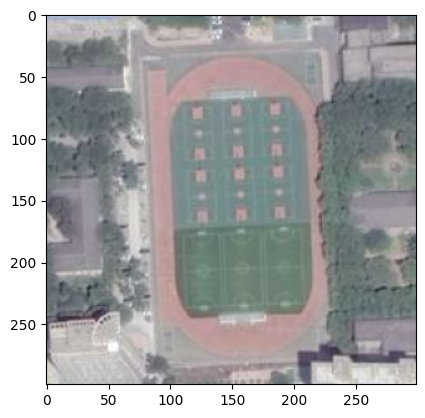

Predicted Caption:  a playground with three basketball fields next to it is surrounded by many buildings


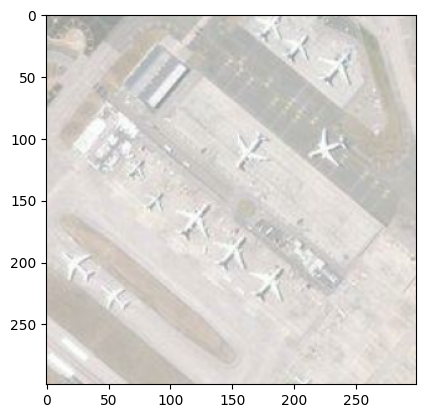

Predicted Caption:  a large building is near a parking lot


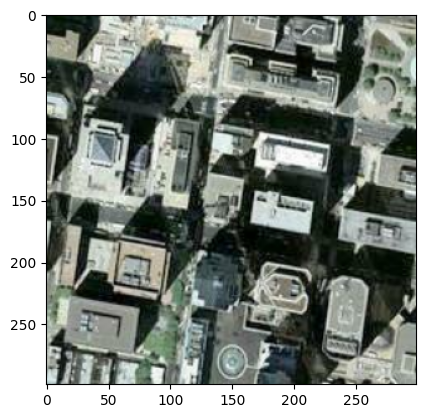

Predicted Caption:  many buildings are in a school


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list((df_valid["filename"]))


def generate_caption(path):
    # Select a random image from the validation dataset
    sample_img = path          #valid_images[value]              #np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)




# Check predictions for a few samples
generate_caption("/content/drive/MyDrive/Colab Notebooks/Enhanced_image_testing/00623 (1).jpg")
generate_caption("/content/drive/MyDrive/Colab Notebooks/Enhanced_image_testing/airport_4 (1).jpg")
generate_caption("/content/drive/MyDrive/Colab Notebooks/Enhanced_image_testing/commercial_62 (1).jpg")
